In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sn
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout, InputLayer, Activation,concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

In [2]:
# Google's stock price
data=yf.download("GOOG")

[*********************100%***********************]  1 of 1 completed


In [3]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,2.490664,2.591785,2.390042,2.499133,2.499133,897427216
2004-08-20,2.515820,2.716817,2.503118,2.697639,2.697639,458857488
2004-08-23,2.758411,2.826406,2.716070,2.724787,2.724787,366857939
2004-08-24,2.770615,2.779581,2.579581,2.611960,2.611960,306396159
2004-08-25,2.614201,2.689918,2.587302,2.640104,2.640104,184645512
...,...,...,...,...,...,...
2023-08-07,129.509995,132.059998,129.429993,131.940002,131.940002,17621000
2023-08-08,130.979996,131.940002,130.130005,131.839996,131.839996,16836000
2023-08-09,132.190002,132.470001,129.505005,130.149994,130.149994,17745200


In [4]:
# making a copy of data
df=data.copy()

In [5]:
# Storing rolling means of different window size
df['rm_7']=df['Close'].rolling(7).mean()
df['rm_30']=df['Close'].rolling(30).mean()
df['rm_90']=df['Close'].rolling(90).mean()
df['rm_180']=df['Close'].rolling(180).mean()

In [6]:
df['Target'] = df['Adj Close']-df.Open
df['Target'] = df['Target'].shift(-1)
df['TargetClass'] = [1 if df['Target'][i]>0 else 0 for i in range(len(df)) ]
df['TargetNextClose'] = df['Adj Close'].shift(-1)

df.dropna(inplace=True)
df.reset_index(inplace=True)
df.drop(['Close','Volume','Date'],axis=1,inplace=True)

In [7]:
df

,Open,High,Low,Adj Close,rm_7,rm_30,rm_90,rm_180,Target,TargetClass,TargetNextClose
0,5.694157,5.694157,5.625913,5.653310,5.561974,4.971922,4.818378,4.276256,-0.009464,0,5.679213
1,5.688677,5.709848,5.640608,5.679213,5.591293,5.012412,4.828136,4.293923,-0.049315,0,5.629400
2,5.678715,5.691168,5.614705,5.629400,5.614669,5.049440,4.837302,4.310211,0.058032,1,5.673733
3,5.615701,5.673733,5.597021,5.673733,5.642422,5.089482,4.845660,4.326594,0.057784,1,5.760658
4,5.702874,5.777843,5.676971,5.760658,5.674445,5.131690,4.856314,4.344087,-0.052054,0,5.696648
...,...,...,...,...,...,...,...,...,...,...,...
4593,129.600006,131.929993,128.315002,128.539993,130.547141,123.736333,117.492278,106.535583,2.430008,1,131.940002
4594,129.509995,132.059998,129.429993,131.940002,130.842856,124.033666,117.832056,106.720139,0.860001,1,131.839996
4595,130.979996,131.940002,130.130005,131.839996,130.675714,124.458666,118.164722,106.902639,-2.040009,0,130.149994
4596,132.190002,132.470001,129.505005,130.149994,130.252856,124.829999,118.485055,107.078472,-1.759995,0,130.210007


<Axes: >

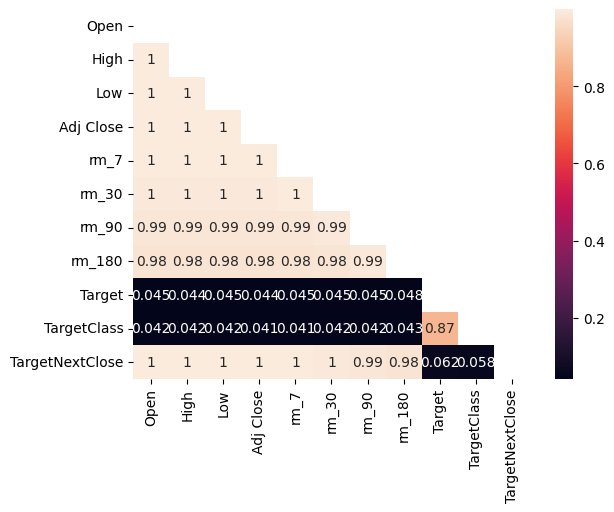

In [8]:
sn.heatmap(df.corr(method='spearman'),annot=True,mask=np.triu(df.corr(method='spearman')))

In [9]:
le = MinMaxScaler()

In [10]:
df = le.fit_transform(df)

In [11]:
backcandles=30

In [12]:
df.shape

(4598, 11)

In [13]:
X=np.array([df[i:i+backcandles,:-1] for i in range(len(df)-backcandles+1)])

In [14]:
X.shape

(4569, 30, 10)

In [15]:
Y=df[backcandles-1:,-1:]

In [16]:
X.shape,Y.shape

((4569, 30, 10), (4569, 1))

In [17]:
x_train = X[:int(X.shape[0]*.9)]
y_train = Y[:int(X.shape[0]*.9)]
x_val = X[int(X.shape[0]*.9):int(X.shape[0]*.95)]
y_val = Y[int(X.shape[0]*.9):int(X.shape[0]*.95)]
x_test = X[int(X.shape[0]*.95):]
y_test = Y[int(X.shape[0]*.95):]

In [18]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape,x_val.shape,y_val.shape

((4112, 30, 10), (4112, 1), (229, 30, 10), (229, 1), (228, 30, 10), (228, 1))

In [48]:
model = Sequential()
model.add(LSTM(32,input_shape=(backcandles,x_train.shape[-1]),return_sequences=False))
# model.add(LSTM(32,return_sequences=False))
# model.add(LSTM(16,return_sequences=False))
model.add(Dropout(.1))
model.add(Dense(1,'linear'))

In [49]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 32)                5504      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,537
Trainable params: 5,537
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='mse',metrics=['RootMeanSquaredError'])

In [51]:
history = model.fit(x=x_train,y=y_train,
                    validation_data=(x_val,y_val),
                    epochs = 500, batch_size = 64,
                    verbose=0,
                    # callbacks=[EarlyStopping(monitor='val_loss', patience=15,verbose=0)]
                    )

<Axes: >

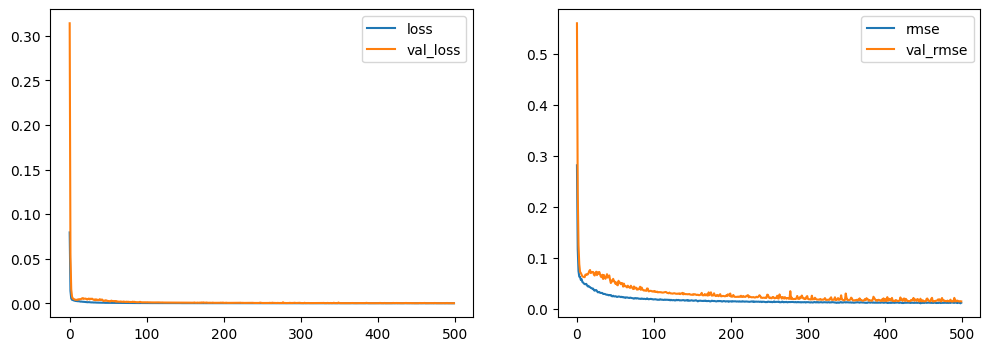

In [52]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sn.lineplot(history.history['loss'],label='loss')
sn.lineplot(history.history['val_loss'],label='val_loss')
plt.subplot(1,2,2)
sn.lineplot(history.history['root_mean_squared_error'],label='rmse')
sn.lineplot(history.history['val_root_mean_squared_error'],label='val_rmse')


8/8 [==============================] - 0s 4ms/step


<Axes: >

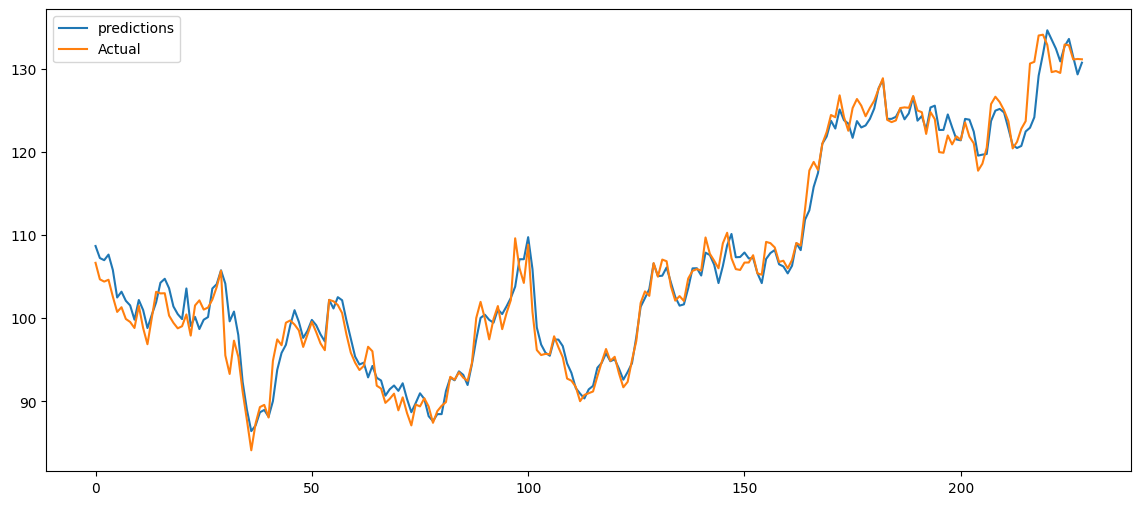

In [56]:
y_predicted=model.predict(x_test)
plt.figure(figsize=(14,6))
sn.lineplot(le.inverse_transform(np.repeat(y_predicted,11,axis=1))[:,0],label='predictions')
sn.lineplot(le.inverse_transform(np.repeat(y_test,11,axis=1))[:,0],label='Actual')


In [54]:
np.mean(np.square(y_test-y_predicted))

0.0001683236563541497

In [59]:
model.save("./saved\ model")